# Assignment 7

In this assignment, you will familiarize yourself with a typical neural network training and evaluation workflow. You will construct a dataset framework for batched training, create your own implementations of common neural network operations, and train your model on the Fashion-MNIST dataset. You will accomplish this in the PyTorch environment. To use PyTorch install the API on your local machine.


In [1]:
# Import all dependencies
import torch
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)

# Ignore warnings
warnings.filterwarnings("ignore")

### Data Retrieval


In [2]:
# Load the Fashion-MNIST dataset
transform = transforms.ToTensor()
fashion_mnist_train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
fashion_mnist_test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

# Define a class names
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### Data Preprocessing and Visualization


Train Data -> Min value: 0.0, Max value: 1.0
Test Data -> Min value: 0.0, Max value: 1.0


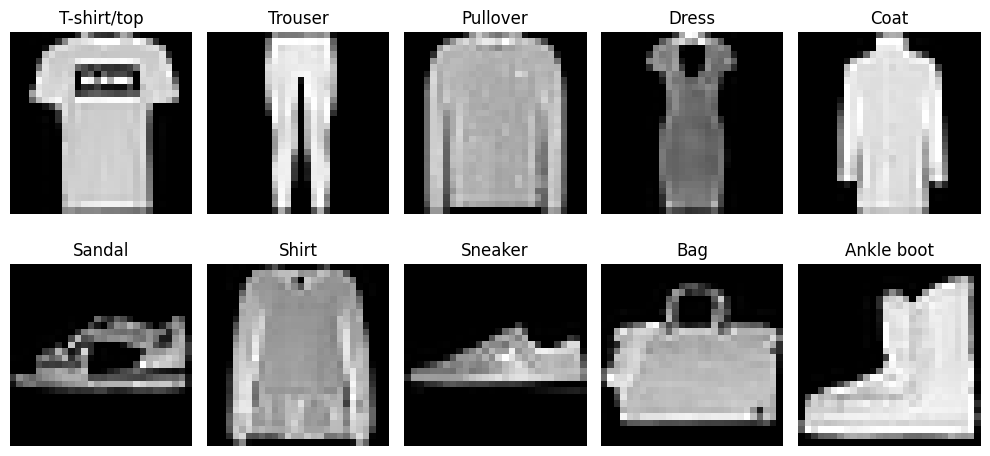

In [3]:
# Normalize the samples to the range [0, 1]
fashion_mnist_train_dataset.data = fashion_mnist_train_dataset.data.float() / 255
fashion_mnist_test_dataset.data = fashion_mnist_test_dataset.data.float() / 255
print(
    f"Train Data -> Min value: {torch.min(fashion_mnist_train_dataset.data)}, Max value: {torch.max(fashion_mnist_train_dataset.data)}"
)
print(
    f"Test Data -> Min value: {torch.min(fashion_mnist_test_dataset.data)}, Max value: {torch.max(fashion_mnist_test_dataset.data)}"
)

# Get a batch of images and labels
images, labels = (
    fashion_mnist_train_dataset.data[:100],
    fashion_mnist_train_dataset.targets[:100],
)

# Visualize one random member from each of the 10 classes
plt.figure(figsize=(10, 5))
for index, class_name in enumerate(class_names):
    # Get the first sample of the current class
    class_indices = (labels == index).nonzero()

    # Get a random sample from the current class
    random_index = class_indices[np.random.randint(0, class_indices.size(0))]

    # Get the image and label of the random sample
    image = images[random_index].squeeze().numpy()

    # Plot the image
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap="gray")
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Data Analysis


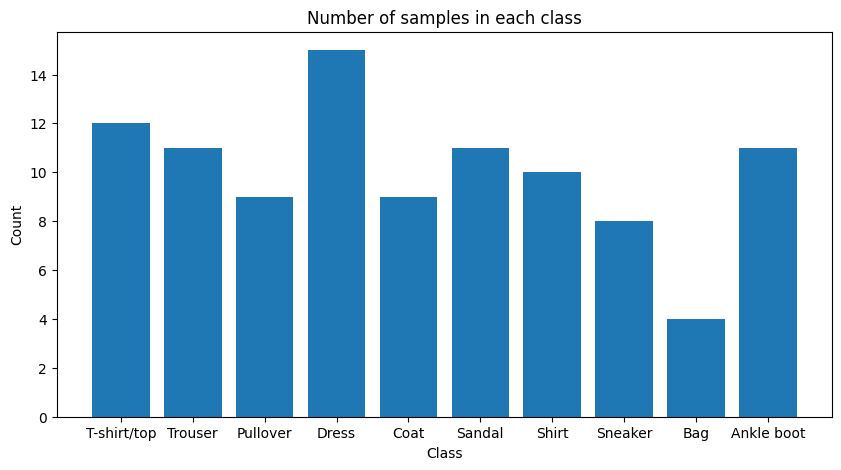

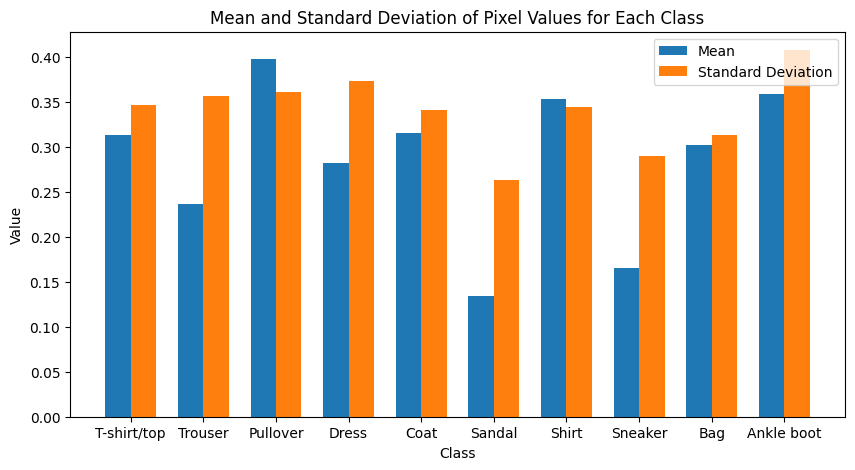

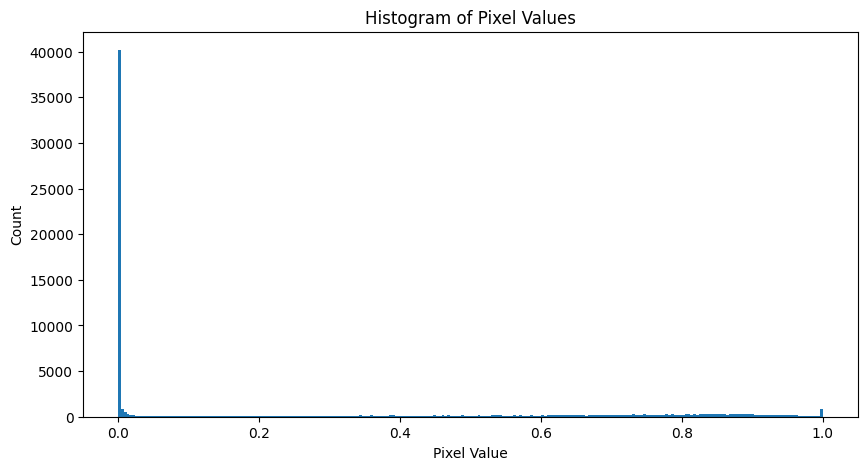

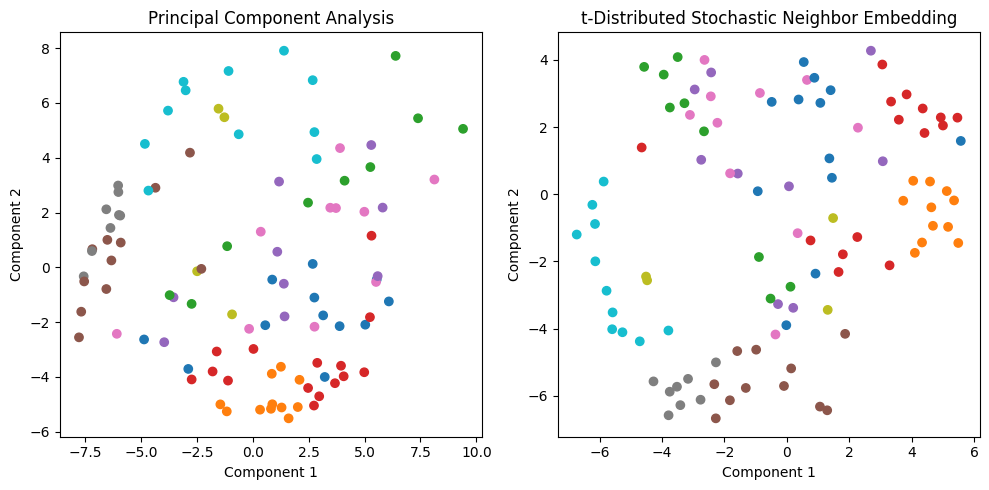

In [4]:
# Define a list of indices
index = np.arange(len(class_names))

# Count the number of samples in each class
class_counts = [torch.sum(labels == index).item() for index in range(len(class_names))]

# Plot the distribution of of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(index, class_counts)
plt.title("Number of samples in each class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(index, class_names)
plt.show()

# Calculate mean and standard deviation of each class
class_means = [
    torch.mean(images[labels == index]).item() for index in range(len(class_names))
]
class_stds = [
    torch.std(images[labels == index]).item() for index in range(len(class_names))
]

# Plot the distribution of mean and standard deviation of each class
bar_width = 0.35
plt.figure(figsize=(10, 5))
plt.bar(index, class_means, bar_width, label="Mean")
plt.bar(index + bar_width, class_stds, bar_width, label="Standard Deviation")
plt.title("Mean and Standard Deviation of Pixel Values for Each Class")
plt.xlabel("Class")
plt.ylabel("Value")
plt.xticks(index + bar_width / 2, class_names)
plt.legend()
plt.show()

# Flatten the images to 1D vectors
images = images.view(images.shape[0], -1)

# Create a histogram of pixel values
plt.figure(figsize=(10, 5))
plt.hist(images.flatten(), bins=255, range=(0, 1))
plt.title("Histogram of Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Count")
plt.show()

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca.fit(images)
images_pca = pca.transform(images)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
images_tsne = tsne.fit_transform(images)

# Create two scatter plots of the reduced data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap="tab10")
plt.title("Principal Component Analysis")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.subplot(1, 2, 2)
plt.scatter(images_tsne[:, 0], images_tsne[:, 1], c=labels, cmap="tab10")
plt.title("t-Distributed Stochastic Neighbor Embedding")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

### Datasets and Data Splitting


Number of training batches: 750 (48000 samples)
Number of validation batches: 188 (12000 samples)


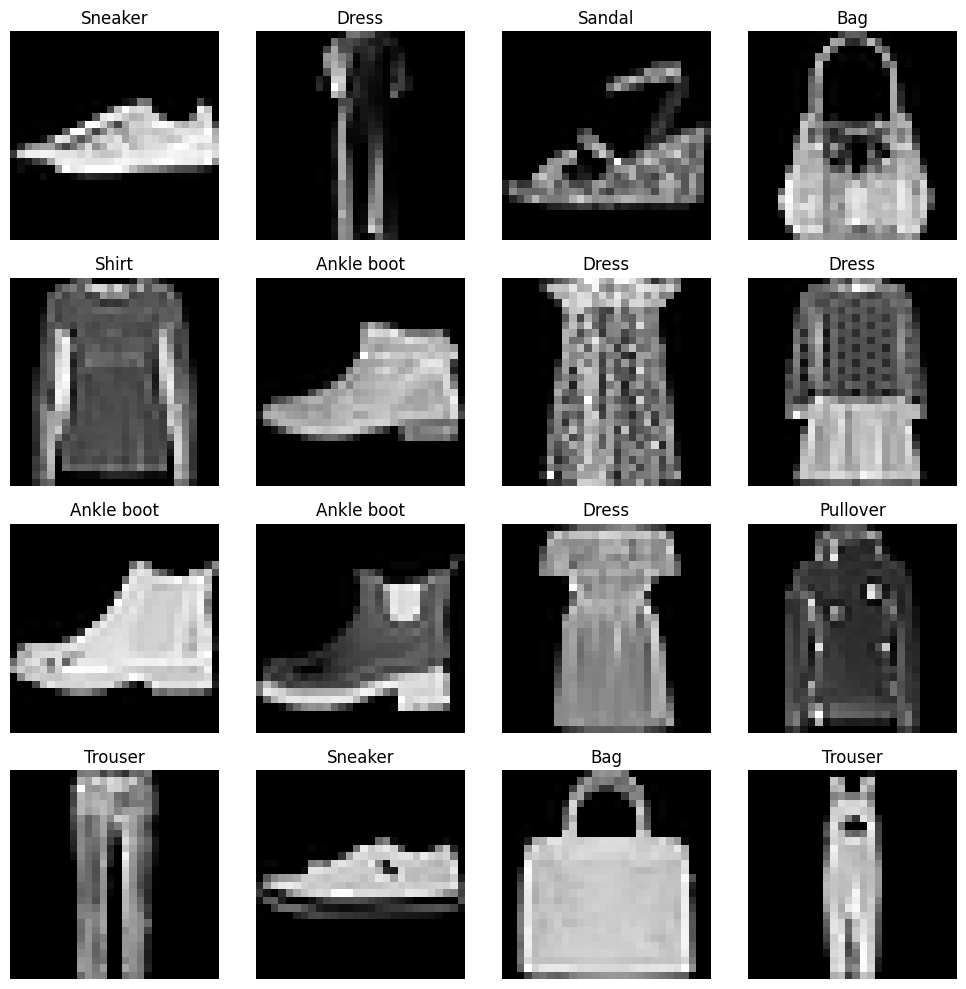

In [5]:
# Split the data into training and validating sets (80% training, 20% testing)
train_data, val_data, train_labels, val_labels = train_test_split(
    fashion_mnist_train_dataset.data,
    fashion_mnist_train_dataset.targets,
    test_size=0.2,
    random_state=42,
)

# Reshape the data to [N, 1, 28, 28]
train_data = train_data.unsqueeze(1).float()
val_data = val_data.unsqueeze(1).float()

# Convert the data to tensor
# train_data = torch.tensor(train_data)
# val_data = torch.tensor(val_data)

# Convert labels to one-hot encoding
train_labels = nn.functional.one_hot(train_labels)
val_labels = nn.functional.one_hot(val_labels)


# Create a custom dataset class
class Dataset:
    def __init__(self, samples, labels, batch_size):
        self.samples = samples
        self.labels = labels
        self.batch_size = batch_size
        self.num_samples = len(samples)
        self.num_batches = np.ceil(self.num_samples / self.batch_size).astype(int)
        self.indices = np.arange(self.num_samples)
        return

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, self.num_samples)

        indices = self.indices[start_index:end_index]

        batch_samples = self.samples[indices]
        batch_labels = self.labels[indices]

        return batch_samples, batch_labels

    def __len__(self):
        return self.num_batches

    def shuffle(self):
        self.indices = np.random.permutation(self.indices)
        return


# Create training dataset
train_dataset = Dataset(train_data, train_labels, batch_size=64)

# Create validation dataset
val_dataset = Dataset(val_data, val_labels, batch_size=64)

# Print the size of the training and validation datasets
print(f"Number of training batches: {len(train_dataset)} ({len(train_data)} samples)")
print(f"Number of validation batches: {len(val_dataset)} ({len(val_data)} samples)")

# Visualize 16 samples from a batch
images, labels = next(iter(train_dataset))
images = images.squeeze().numpy()
labels = labels.argmax(axis=1)
plt.figure(figsize=(10, 10))
for index in range(16):
    plt.subplot(4, 4, index + 1)
    plt.imshow(images[index], cmap="gray")
    plt.title(class_names[labels[index]])
    plt.axis("off")
plt.tight_layout()
plt.show()

### General Configuration


[Conv2d] Max difference: 1.7881393432617188e-07
[MaxPool2d] Max difference: 0.0
[ReLU] Max difference: 0.0


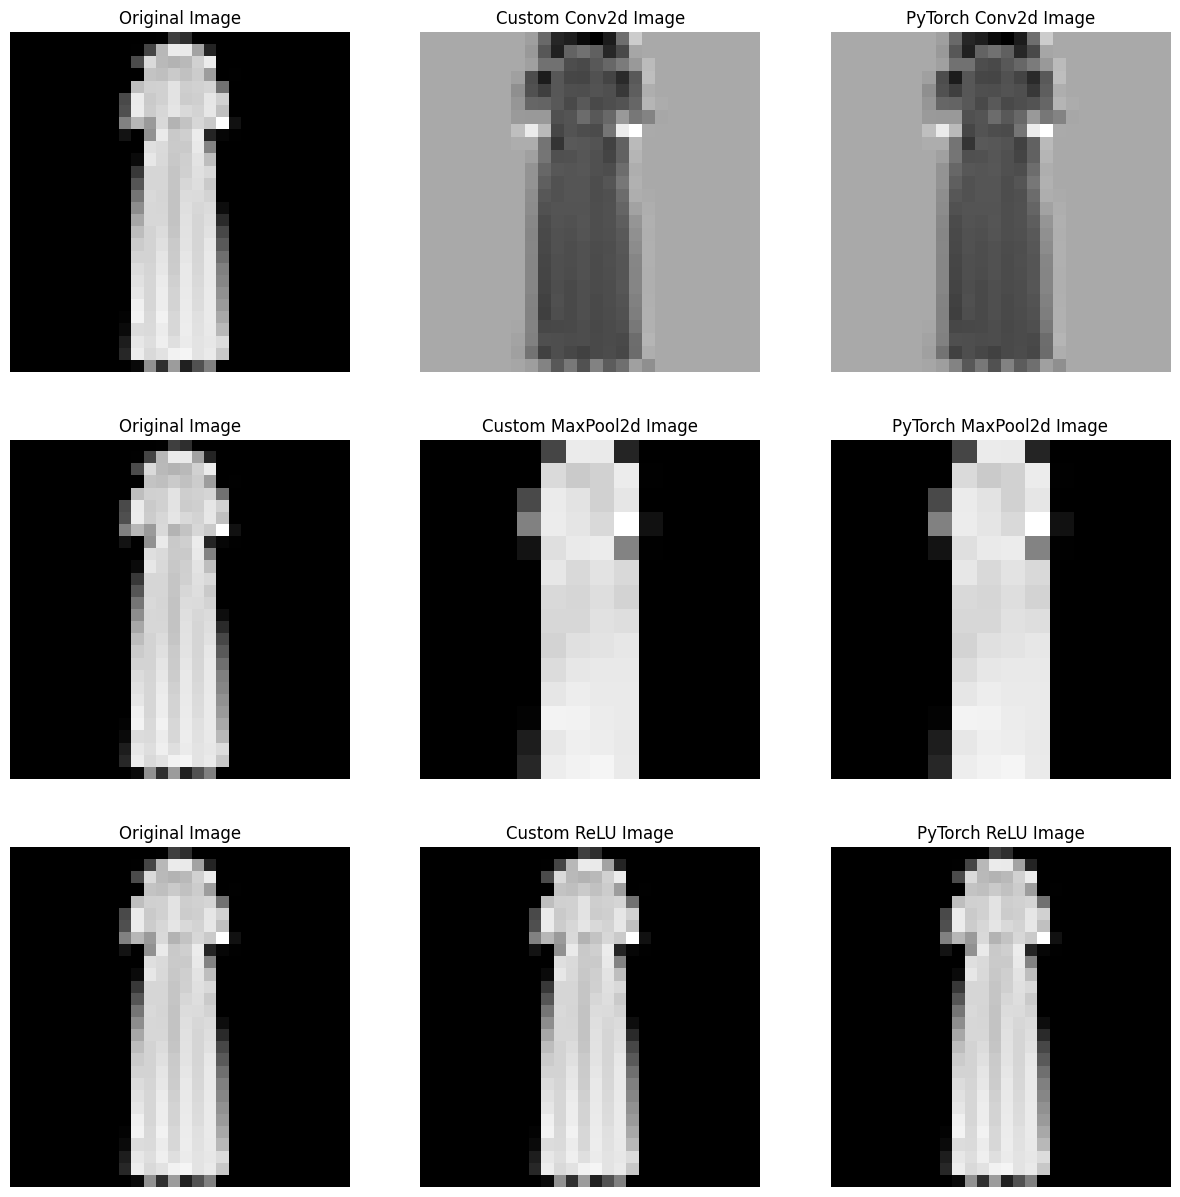

In [6]:
# Create a custom two-dimensional convolutional class
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.weight = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.01
        )
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        return

    def forward(self, x):
        # Flag that indicates that the input does not have a channel dimension
        no_channel = False

        # If the x does not have a channel dimension, add it
        if len(x.shape) == 3:
            no_channel = True
            x = x.unsqueeze(1)

        # Get the dimensions of the input
        batch_size, channels, in_height, in_width = x.shape

        # Get the dimensions of the kernel
        out_channels, channels, kernel_height, kernel_width = self.weight.shape

        # Calculate the output dimensions
        out_height = 1 + (in_height - kernel_height) // self.stride
        out_width = 1 + (in_width - kernel_width) // self.stride

        # Define unfold and fold transformations
        unfold = nn.Unfold(
            kernel_size=(kernel_height, kernel_width), stride=self.stride
        )
        fold = nn.Fold(
            output_size=(out_height, out_width),
            kernel_size=(1, 1),
            stride=(1, 1),
        )

        # Reshape the input tensor
        unfold_x = unfold(x)

        # Reshape the weight tensor
        weight = self.weight.view(out_channels, -1)

        # Reshape the bias tensor
        bias = self.bias.unsqueeze(-1)

        # Perform the convolution (element-wise multiplication and summation)
        output = torch.matmul(weight, unfold_x) + bias

        # Reshape the output tensor
        output = fold(output)

        # If the x does not have a channel dimension, remove it
        if no_channel:
            output = output.squeeze(1)

        return output

        ########################################################################
        # Note: the following code is a naive implementation of the convolution
        ########################################################################
        # # Create an empty output tensor
        # output = torch.zeros(batch_size, out_channels, out_height, out_width)

        # # Loop over each batch
        # for batch in range(batch_size):
        #     # Loop over each channel
        #     for out_channel in range(out_channels):
        #         # Loop over each row
        #         for row in range(out_height):
        #             # Loop over each column
        #             for column in range(out_width):
        #                 # Get the current slice
        #                 slice = x[
        #                     batch,
        #                     :,
        #                     row * self.stride : row * self.stride + kernel_height,
        #                     column * self.stride : column * self.stride + kernel_width,
        #                 ]

        #                 # Perform the convolution
        #                 output[batch, out_channel, row, column] = (
        #                     torch.sum(slice * self.weight[out_channel])
        #                     + self.bias[out_channel]
        #                 )

        # return output


class MaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        return

    def forward(self, x):
        # Flag that indicates that the input does not have a channel dimension
        no_channel = False

        # If the x does not have a channel dimension, add it
        if len(x.shape) == 3:
            no_channel = True
            x = x.unsqueeze(1)

        # Get the dimensions of the input
        batch_size, channels, in_height, in_width = x.shape

        # Calculate the output dimensions
        out_height = 1 + (in_height - self.kernel_size) // self.stride
        out_width = 1 + (in_width - self.kernel_size) // self.stride

        # Define unfold transformations
        unfold = nn.Unfold(
            kernel_size=(self.kernel_size, self.kernel_size), stride=self.stride
        )

        # Reshape the input tensor (pooling size has to the same as the last dimension)
        unfold_x = unfold(x).view(batch_size, channels, -1, out_height * out_width)

        # Perform max pooling
        output = torch.max(unfold_x, dim=2).values

        # Reshape the output tensor to the output shape
        output = output.view(batch_size, channels, out_height, out_width)

        # If the x does not have a channel dimension, remove it
        if no_channel:
            output = output.squeeze(1)

        return output

        ########################################################################
        # Note: the following code is a naive implementation of the max pooling
        ########################################################################
        # # Create an empty output tensor
        # output = torch.zeros(batch_size, in_channels, out_height, out_width)

        # # Loop over each batch
        # for batch in range(batch_size):
        #     # Loop over each channel
        #     for channel in range(in_channels):
        #         # Loop over each row
        #         for row in range(out_height):
        #             # Loop over each column
        #             for column in range(out_width):
        #                 # Get the current slice
        #                 slice = x[
        #                     batch,
        #                     channel,
        #                     row * self.stride : row * self.stride + self.kernel_size,
        #                     column * self.stride : column * self.stride
        #                     + self.kernel_size,
        #                 ]

        #                 # Perform the max pooling
        #                 output[batch, channel, row, column] = torch.max(slice)

        # return output


class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        return

    def forward(self, x):
        # Calculate the output based on the ReLU function
        return torch.max(x, torch.zeros_like(x))


# Helper function to compare custom and PyTorch implementations
def compare_results(method, custom_layer, torch_layer, x):
    # Use PyTorch layer to get the reference result
    result_torch = torch_layer(x)

    # Use custom layer
    result_custom = custom_layer(x)

    # Compare results
    differences = torch.abs(result_custom - result_torch)
    max_difference = differences.max().item()
    print(f"[{method}] Max difference: {max_difference}")
    return


# Add a channel dimension to the images and convert it to tensor
test_x, _ = next(iter(train_dataset))

# Subtract the small value from images to test the ReLU function
test_x -= 0.1

# Test Conv2d
custom_conv = Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1)
torch_conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1)
custom_conv.weight = torch_conv.weight
custom_conv.bias = torch_conv.bias
compare_results("Conv2d", custom_conv, torch_conv, test_x)

# Test MaxPool2d
custom_maxpool = MaxPool2d(kernel_size=2, stride=2)
torch_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
compare_results("MaxPool2d", custom_maxpool, torch_maxpool, test_x)

# Test ReLU
custom_relu = ReLU()
torch_relu = nn.ReLU()
compare_results("ReLU", custom_relu, torch_relu, test_x)

# Test this on a random image
image = torch.tensor(images[np.random.randint(0, len(images))])

# Test Conv2d
custom_conv = Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
torch_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
custom_conv.weight = torch_conv.weight
custom_conv.bias = torch_conv.bias

# Test MaxPool2d
custom_maxpool = MaxPool2d(kernel_size=2, stride=2)
torch_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

# Test ReLU
custom_relu = ReLU()
torch_relu = nn.ReLU()

# Get the outputs of the functions
custom_conv_image = (
    custom_conv(image.unsqueeze(0).unsqueeze(0)).squeeze().detach().numpy()
)
torch_conv_image = (
    torch_conv(image.unsqueeze(0).unsqueeze(0)).squeeze().detach().numpy()
)
custom_maxpool_image = (
    custom_maxpool(image.unsqueeze(0).unsqueeze(0)).squeeze().detach().numpy()
)
torch_maxpool_image = (
    torch_maxpool(image.unsqueeze(0).unsqueeze(0)).squeeze().detach().numpy()
)
custom_relu_image = (
    custom_relu(image.unsqueeze(0).unsqueeze(0)).squeeze().detach().numpy()
)
torch_relu_image = (
    torch_relu(image.unsqueeze(0).unsqueeze(0)).squeeze().detach().numpy()
)

_, (
    (ax11, ax12, ax13),
    (ax21, ax22, ax23),
    (ax31, ax32, ax33),
) = plt.subplots(3, 3, figsize=(15, 15))
ax11.imshow(image, cmap="gray")
ax11.set_title("Original Image")
ax11.axis("off")
ax12.imshow(custom_conv_image, cmap="gray")
ax12.set_title("Custom Conv2d Image")
ax12.axis("off")
ax13.imshow(torch_conv_image, cmap="gray")
ax13.set_title("PyTorch Conv2d Image")
ax13.axis("off")
ax21.imshow(image, cmap="gray")
ax21.set_title("Original Image")
ax21.axis("off")
ax22.imshow(custom_maxpool_image, cmap="gray")
ax22.set_title("Custom MaxPool2d Image")
ax22.axis("off")
ax23.imshow(torch_maxpool_image, cmap="gray")
ax23.set_title("PyTorch MaxPool2d Image")
ax23.axis("off")
ax31.imshow(image, cmap="gray")
ax31.set_title("Original Image")
ax31.axis("off")
ax32.imshow(custom_relu_image, cmap="gray")
ax32.set_title("Custom ReLU Image")
ax32.axis("off")
ax33.imshow(torch_relu_image, cmap="gray")
ax33.set_title("PyTorch ReLU Image")
ax33.axis("off")
plt.show()

### Order of Operations


MaxPool2d -> ReLU: torch.Size([1, 49, 49])
ReLU -> MaxPool2d: torch.Size([1, 49, 49])
MaxPool2d -> ReLU: Min: 0.0, Max: 0.9998382329940796
ReLU -> MaxPool2d: Min: 0.0, Max: 0.9998382329940796
Max difference: 0.0


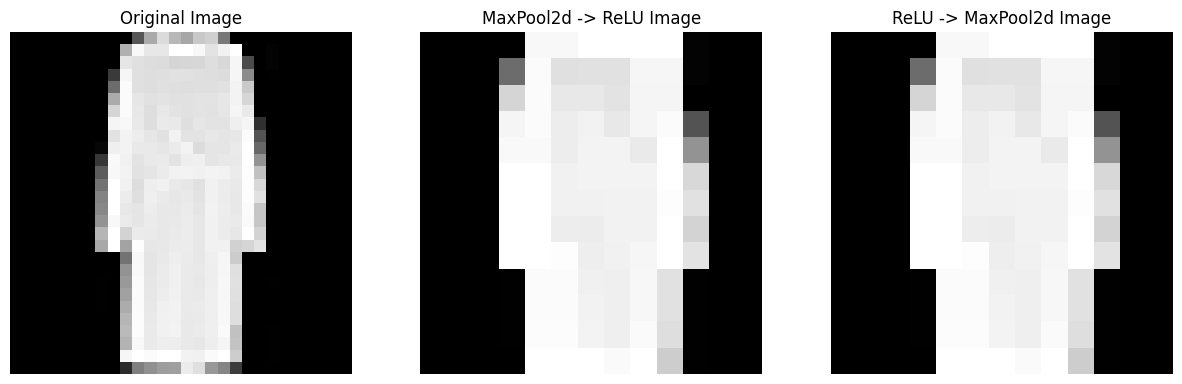

In [7]:
# Create a tensor of dimensions [1, 100, 100] with random values in the range [-1, 1]
x = torch.rand(1, 100, 100) * 2 - 1

# Function MaxPool2d followed by ReLU
maxpool_relu = nn.Sequential(MaxPool2d(kernel_size=3, stride=2), ReLU())

# Function ReLU followed by MaxPool2d
relu_maxpool = nn.Sequential(ReLU(), MaxPool2d(kernel_size=3, stride=2))

maxpool_relu_output = maxpool_relu(x)
relu_maxpool_output = relu_maxpool(x)

# Compare the outputs of the two functions
print(f"MaxPool2d -> ReLU: {maxpool_relu_output.shape}")
print(f"ReLU -> MaxPool2d: {relu_maxpool_output.shape}")

# Calculate the min and max values of the two outputs
print(
    f"MaxPool2d -> ReLU: Min: {torch.min(maxpool_relu_output)}, Max: {torch.max(maxpool_relu_output)}"
)
print(
    f"ReLU -> MaxPool2d: Min: {torch.min(relu_maxpool_output)}, Max: {torch.max(relu_maxpool_output)}"
)

# Calculate the difference between the two outputs
difference = torch.abs(maxpool_relu_output - relu_maxpool_output)
print(f"Max difference: {torch.max(difference)}")

# Test this on a random image
image = torch.tensor(images[np.random.randint(0, len(images))])

# Get the outputs of the two functions
maxpool_relu_image = maxpool_relu(image.unsqueeze(0).unsqueeze(0)).squeeze()
relu_maxpool_image = relu_maxpool(image.unsqueeze(0).unsqueeze(0)).squeeze()

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image, cmap="gray")
ax1.set_title("Original Image")
ax1.axis("off")
ax2.imshow(maxpool_relu_image, cmap="gray")
ax2.set_title("MaxPool2d -> ReLU Image")
ax2.axis("off")
ax3.imshow(relu_maxpool_image, cmap="gray")
ax3.set_title("ReLU -> MaxPool2d Image")
ax3.axis("off")
plt.show()

Max-pooling and monotonically increasing non-linearities exhibit commutativity, implying that MaxPool(Relu(x)) is equal to Relu(MaxPool(x)) for any input. Consequently, the results are identical in this case. Therefore, it is technically more efficient to first subsample through max-pooling and then apply the non-linearity, especially if the non-linearity is computationally expensive. However, in practice, it is often performed the other way around, and this doesn't seem to significantly impact performance.

In the case of Conv2D, it does not flip the kernel; it precisely follows the definition of convolution. Since this is a linear operation, introducing non-linearity needs to be done in the subsequent step.

The "proof" of the following is provided below.


In [8]:
# Define a 2x2 matrix
x = torch.tensor([[1.0, -2.0], [3.0, 4.0]])

# Define a 2x2 convolutional kernel
kernel = torch.tensor([[0.5, -0.5], [1.0, 0.5]])

# Apply max-pooling followed by ReLU
maxpool_relu = F.relu(
    F.max_pool2d(x.unsqueeze(0).unsqueeze(0), kernel_size=2, stride=1)
    .squeeze(0)
    .squeeze(0)
).squeeze()

# Apply ReLU followed by max-pooling
relu_maxpool = (
    F.max_pool2d(F.relu(x.unsqueeze(0).unsqueeze(0)), kernel_size=2, stride=1)
    .squeeze(0)
    .squeeze(0)
).squeeze()

# Apply Conv2D followed by ReLU
conv_relu = F.relu(
    F.conv2d(
        x.unsqueeze(0).unsqueeze(0),
        kernel.unsqueeze(0).unsqueeze(0),
        stride=1,
        padding=0,
    ).squeeze()
)

# Apply ReLU followed by Conv2D
relu_conv = F.conv2d(
    F.relu(x.unsqueeze(0).unsqueeze(0)),
    kernel.unsqueeze(0).unsqueeze(0),
    stride=1,
    padding=0,
).squeeze()

# Display the matrix and results
print(f"Input Matrix: \n{x.numpy()}")
print(f"MaxPool -> ReLU: \t{maxpool_relu}")
print(f"ReLU -> MaxPool: \t{relu_maxpool}")
print(f"Conv2D -> ReLU: \t{conv_relu}")
print(f"ReLU -> Conv2D: \t{relu_conv}")

Input Matrix: 
[[ 1. -2.]
 [ 3.  4.]]
MaxPool -> ReLU: 	4.0
ReLU -> MaxPool: 	4.0
Conv2D -> ReLU: 	6.5
ReLU -> Conv2D: 	5.5


### Artificial Neural Network


In [9]:
# Create a custom neural network class
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.f = nn.Sequential(
            Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1),
            MaxPool2d(kernel_size=3, stride=2),
            ReLU(),
            Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            MaxPool2d(kernel_size=3, stride=2),
            ReLU(),
            Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.f(x)


# Create a PyTorch neural network class
class PyTorchNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.f = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(),
            Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.f(x)

#### Model Training


Training the custom model...


Epoch 1 (Validation): 100%|██████████| 188/188 [00:08<00:00, 22.30it/s]


Epoch 1: Training Loss = 2.3017222379048667, Validation Loss = 2.3000099595556867


Epoch 2 (Validation): 100%|██████████| 188/188 [00:08<00:00, 21.95it/s]


Epoch 2: Training Loss = 2.170992415904999, Validation Loss = 1.4027484553925536


Epoch 3 (Validation): 100%|██████████| 188/188 [00:08<00:00, 22.17it/s]


Epoch 3: Training Loss = 1.036414704879125, Validation Loss = 0.8562791122401014


Epoch 4 (Validation): 100%|██████████| 188/188 [00:07<00:00, 24.41it/s]


Epoch 4: Training Loss = 0.7756485994259517, Validation Loss = 0.7076353421236606


Epoch 5 (Validation): 100%|██████████| 188/188 [00:06<00:00, 27.22it/s]


Epoch 5: Training Loss = 0.6778024406433105, Validation Loss = 0.6467578858137131


Epoch 6 (Validation): 100%|██████████| 188/188 [00:07<00:00, 26.09it/s]


Epoch 6: Training Loss = 0.6201909610827764, Validation Loss = 0.6017750043501245


Epoch 7 (Validation): 100%|██████████| 188/188 [00:07<00:00, 24.97it/s]


Epoch 7: Training Loss = 0.5821690280834834, Validation Loss = 0.5612054013825477


Epoch 8 (Validation): 100%|██████████| 188/188 [00:07<00:00, 24.64it/s]


Epoch 8: Training Loss = 0.5543388340473175, Validation Loss = 0.5552989103375597


Epoch 9 (Validation): 100%|██████████| 188/188 [00:07<00:00, 23.80it/s]


Epoch 9: Training Loss = 0.5349482021729152, Validation Loss = 0.5260493469999191


Epoch 10 (Validation): 100%|██████████| 188/188 [00:07<00:00, 24.13it/s]


Epoch 10: Training Loss = 0.5175643066167831, Validation Loss = 0.5106311614843125
Training the PyTorch model...


Epoch 1 (Validation): 100%|██████████| 188/188 [00:02<00:00, 64.55it/s]


Epoch 1: Training Loss = 1.2444267336527506, Validation Loss = 0.7751698642969131


Epoch 2 (Validation): 100%|██████████| 188/188 [00:02<00:00, 65.53it/s]


Epoch 2: Training Loss = 0.697728548804919, Validation Loss = 0.6332429284428028


Epoch 3 (Validation): 100%|██████████| 188/188 [00:02<00:00, 71.17it/s]


Epoch 3: Training Loss = 0.607233648220698, Validation Loss = 0.5716089794927455


Epoch 4 (Validation): 100%|██████████| 188/188 [00:02<00:00, 72.62it/s]


Epoch 4: Training Loss = 0.5559586489200592, Validation Loss = 0.5336216723031186


Epoch 5 (Validation): 100%|██████████| 188/188 [00:02<00:00, 72.25it/s]


Epoch 5: Training Loss = 0.5210998565355937, Validation Loss = 0.5183643208856278


Epoch 6 (Validation): 100%|██████████| 188/188 [00:02<00:00, 72.66it/s]


Epoch 6: Training Loss = 0.496058153629303, Validation Loss = 0.4979780168926462


Epoch 7 (Validation): 100%|██████████| 188/188 [00:02<00:00, 70.83it/s]


Epoch 7: Training Loss = 0.4755750917593638, Validation Loss = 0.47013699191998926


Epoch 8 (Validation): 100%|██████████| 188/188 [00:02<00:00, 68.22it/s]


Epoch 8: Training Loss = 0.46019040713707604, Validation Loss = 0.4508345721566931


Epoch 9 (Validation): 100%|██████████| 188/188 [00:02<00:00, 72.68it/s]


Epoch 9: Training Loss = 0.44495442624886833, Validation Loss = 0.46016580381609024


Epoch 10 (Validation): 100%|██████████| 188/188 [00:02<00:00, 72.47it/s]


Epoch 10: Training Loss = 0.43103235838810605, Validation Loss = 0.43972916845628557


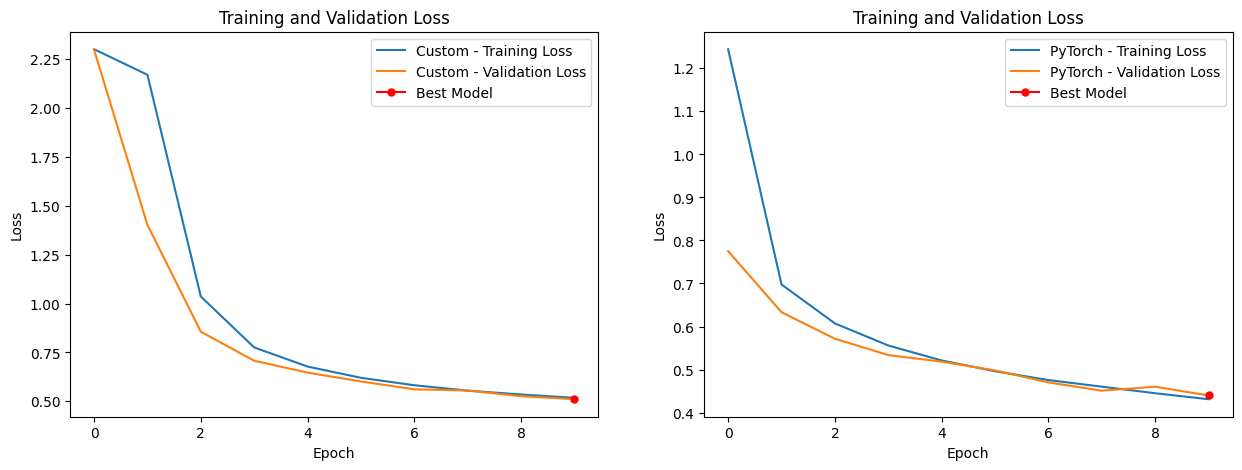

In [10]:
def fit(model, number_of_epochs, train_dataset, val_dataset, optimizer=None):
    # Define the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to the device
    model = model.to(device)

    # Move the datasets to the device
    train_dataset.samples = train_dataset.samples.to(device)
    train_dataset.labels = train_dataset.labels.to(device)
    val_dataset.samples = val_dataset.samples.to(device)
    val_dataset.labels = val_dataset.labels.to(device)

    # Define the best model
    best_model = None
    best_loss = np.inf

    # Define the loss function and variables for tracking loss
    loss_function = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    if optimizer is None:
        # Define the Stochastic Gradient Descent optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # Loop over the epochs
    for epoch in range(number_of_epochs):
        # Set the model to training mode
        model.train()

        # Shuffle the training dataset
        train_dataset.shuffle()

        # Total loss for this epoch
        total_loss = 0.0

        # Loop over the training set
        for index in tqdm(
            range(len(train_dataset)), desc=f"Epoch {epoch + 1} (Training)"
        ):
            # Get the samples and labels
            samples, labels = train_dataset[index]

            # Reset the gradients
            optimizer.zero_grad()

            # Forward propagation
            predictions = model(samples)

            # Calculate the loss
            loss = loss_function(predictions, labels.argmax(axis=1))

            # Backward propagation
            loss.backward()

            # Update the weights
            optimizer.step()

            # Update the total loss
            total_loss += loss.item()

        # Calculate the average loss and append it to the list
        average_loss = total_loss / len(train_dataset)
        train_losses.append(average_loss)

        # Set the model to evaluation mode
        model.eval()

        # Total loss for this epoch
        total_loss = 0.0

        # Loop over the validation set
        for index in tqdm(
            range(len(val_dataset)), desc=f"Epoch {epoch + 1} (Validation)"
        ):
            # Get the samples and labels
            samples, labels = val_dataset[index]

            # Forward propagation
            predictions = model(samples)

            # Calculate the loss
            loss = loss_function(predictions, labels.argmax(axis=1))

            # Update the total loss
            total_loss += loss.item()

        # Calculate the average loss and append it to the list
        average_loss = total_loss / len(val_dataset)
        val_losses.append(average_loss)

        # Save the best model
        if average_loss < best_loss:
            best_loss = average_loss
            best_model = model.state_dict()

        # Print the epoch number, training loss, and validation loss
        print(
            f"Epoch {epoch + 1}: Training Loss = {train_losses[-1]}, Validation Loss = {val_losses[-1]}"
        )

    # Load the best model
    model.load_state_dict(best_model)

    return model, train_losses, val_losses


# Create a custom neural network
custom_model = CustomNeuralNetwork()

# Create a PyTorch neural network
pytorch_model = PyTorchNeuralNetwork()

# Train the models
print("Training the custom model...")
best_custom_model, custom_train_losses, custom_val_losses = fit(
    custom_model, 10, train_dataset, val_dataset
)
print("Training the PyTorch model...")
best_pytorch_model, pytorch_train_losses, pytorch_val_losses = fit(
    pytorch_model, 10, train_dataset, val_dataset
)

# Save the models
torch.save(best_custom_model.state_dict(), "custom_model.pt")
torch.save(best_pytorch_model.state_dict(), "pytorch_model.pt")

# Find the smallest evaluation loss index
custom_best_index = np.argmin(custom_val_losses)
pytorch_best_index = np.argmin(pytorch_val_losses)

# Plot the training and validation losses
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(custom_train_losses, label="Custom - Training Loss")
ax1.plot(custom_val_losses, label="Custom - Validation Loss")
ax1.plot(
    custom_best_index,
    custom_val_losses[custom_best_index],
    marker="o",
    markersize=5,
    color="red",
    label="Best Model",
)
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(pytorch_train_losses, label="PyTorch - Training Loss")
ax2.plot(pytorch_val_losses, label="PyTorch - Validation Loss")
ax2.plot(
    pytorch_best_index,
    pytorch_val_losses[pytorch_best_index],
    marker="o",
    markersize=5,
    color="red",
    label="Best Model",
)
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
plt.show()

### Model Evaluation


In [11]:
def predict(model, dataset):
    # Define the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to the device
    model = model.to(device)

    # Move the datasets to the device
    dataset.samples = dataset.samples.to(device)
    dataset.labels = dataset.labels.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Define labels and predictions
    label_array = []
    prediction_array = []

    # Loop over the test set
    for index in tqdm(range(len(dataset))):
        # Get the samples and labels
        samples, labels = dataset[index]

        # Forward propagation
        predictions = model(samples)

        # Convert the predictions and labels to class labels
        labels = labels.argmax(axis=1)
        predictions = predictions.argmax(axis=1)

        # Append labels and predictions to the arrays
        label_array.extend(labels)
        prediction_array.extend(predictions)

    # Convert the labels and predictions to numpy arrays and flatten them
    label_array = np.array(label_array).flatten()
    prediction_array = np.array(prediction_array).flatten()

    return label_array, prediction_array


def test(model, dataset):
    # Make predictions
    labels, predictions = predict(model, dataset)

    # Calculate the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="macro")
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")

    return accuracy, precision, recall, f1


# Define the test data
test_data = fashion_mnist_test_dataset.data
test_labels = fashion_mnist_test_dataset.targets

# Reshape the data to [N, 1, 28, 28]
test_data = test_data.unsqueeze(1).float()

# Convert the data to tensor
# test_data = torch.tensor(train_data)

# Convert labels to one-hot encoding
test_labels = nn.functional.one_hot(test_labels)

# Create test dataset
test_dataset = Dataset(test_data, test_labels, batch_size=64)

# Print the size of the training and validation datasets
print(f"Number of testing batches: {len(test_dataset)} ({len(test_data)} samples)")

# Test the custom model
print("Testing the custom model...")
(
    custom_accuracy,
    custom_precision,
    custom_recall,
    custom_f1,
) = test(custom_model, test_dataset)

# Test the PyTorch model
print("Testing the PyTorch model...")
(
    pytorch_accuracy,
    pytorch_precision,
    pytorch_recall,
    pytorch_f1,
) = test(pytorch_model, test_dataset)

Number of testing batches: 157 (10000 samples)
Testing the custom model...


100%|██████████| 157/157 [00:06<00:00, 26.13it/s]


Testing the PyTorch model...


100%|██████████| 157/157 [00:02<00:00, 70.65it/s]


### Model Comparison


In [12]:
# Compare the results
print(f"[Custom] Accuracy {custom_accuracy}")
print(f"[Custom] Precision {custom_precision}")
print(f"[Custom] Recall {custom_recall}")
print(f"[Custom] F1 {custom_f1}")
print()
print(f"[PyTorch] Accuracy {pytorch_accuracy}")
print(f"[PyTorch] Precision {pytorch_precision}")
print(f"[PyTorch] Recall {pytorch_recall}")
print(f"[PyTorch] F1 {pytorch_f1}")

[Custom] Accuracy 0.8095
[Custom] Precision 0.8069554027545214
[Custom] Recall 0.8095000000000001
[Custom] F1 0.8072288841067381

[PyTorch] Accuracy 0.8349
[PyTorch] Precision 0.8442990058868501
[PyTorch] Recall 0.8348999999999999
[PyTorch] F1 0.836205001747981


### Diagnostic Plots


100%|██████████| 157/157 [00:02<00:00, 66.32it/s]


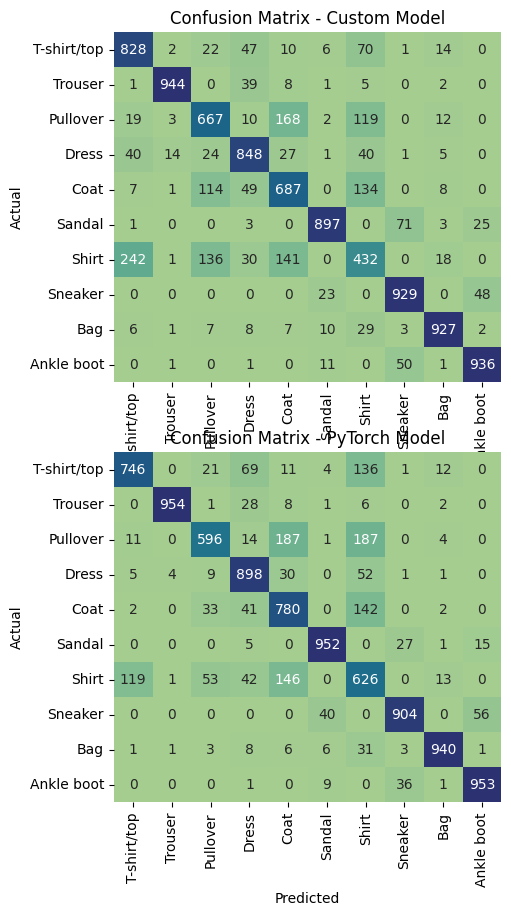

In [13]:
# Function to plot confusion matrix
def plot_confusion_matrix(labels, predictions, class_names, model_name, ax):
    # Calculate the confusion matrix
    matrix = confusion_matrix(labels, predictions, labels=np.arange(len(class_names)))

    # Plot the heatmap of the confusion matrix
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="crest",
        cbar=False,
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix - {model_name}")


# Define models
models = [
    ("Custom Model", custom_model),
    ("PyTorch Model", pytorch_model),
]

_, axes = plt.subplots(len(models), 1, figsize=(5, 10))

# Loop over models and plot confusion matrix
for index, (model_name, model) in enumerate(models):
    # Make predictions
    labels, predictions = predict(model, test_dataset)

    # Plot confusion matrix
    plot_confusion_matrix(labels, predictions, class_names, model_name, axes[index])

plt.show()

As we can see from results above both models perform similarly on the test set. However, the PyTorchs models accuracy is slightly higher than ours. Besides that the model is overall better than ours it is also faster. This might be because our a bit naive implementation of the model.

From the confusion matrix we can see that both models are struggling with the classifying the shirt, pullower and coat class. This might be because these classes are very similar.


### Bonus problem


In [ ]:
# Define a custom data for the grid search
data = fashion_mnist_train_dataset.data
labels = fashion_mnist_train_dataset.targets

# Reshape the data to [N, 1, 28, 28]
data = data.unsqueeze(1).float()

# Convert the data to tensor
# data = torch.tensor(data)

# Convert labels to one-hot encoding
labels = nn.functional.one_hot(labels)

# Set up k-fold cross-validation
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
}

# Define hyperparameters
parameters = {
    "batch_size": [32, 64, 128],
    "learning_rate": [0.001, 0.01, 0.1],
    "number_of_epochs": [10, 20, 30],
}

# Define models
models = [
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.ReLU(),
        Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
        nn.Flatten(),
    ),
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.ReLU(),
        Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
        nn.Flatten(),
    ),
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.ReLU(),
        Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
        nn.Flatten(),
    ),
]

# Define the best model, parameters, and metrics
best_model = None
best_parameters = None
best_metrics = None

# Loop over models
for model in models:
    # Loop over the batch sizes
    for batch_size in parameters["batch_size"]:
        # Create a custom train and test dataset
        train_data, val_data, train_labels, val_labels = train_test_split(
            data,
            labels,
            test_size=0.2,
            random_state=42,
        )
        train_dataset = Dataset(train_data, train_labels, batch_size=batch_size)
        val_dataset = Dataset(val_data, val_labels, batch_size=batch_size)

        # Loop over the learning rates
        for learning_rate in parameters["learning_rate"]:
            # Loop over the number of epochs
            for number_of_epochs in parameters["number_of_epochs"]:
                # Define the optimizer
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

                # Train the model
                model, train_losses, val_losses = fit(
                    model,
                    number_of_epochs,
                    train_dataset,
                    val_dataset,
                    optimizer=optimizer,
                )

                # Make predictions and calculate the metrics
                accuracy, precision, recall, f1 = test(model, val_dataset)

                # Check if the current model is the best model
                if best_metrics is None or f1 > best_metrics["f1"]:
                    best_model = model.state_dict()
                    best_parameters = {
                        "batch_size": batch_size,
                        "learning_rate": learning_rate,
                        "number_of_epochs": number_of_epochs,
                    }
                    best_metrics = {
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                    }

# Print the best model, parameters, and metrics
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_parameters}")
print(f"Best Metrics: {best_metrics}")

# Load the best model
best_model.load_state_dict(best_model)

# Save the best model
torch.save(best_model.state_dict(), "best_model.pt")

# Test the best model
print("Testing the model...")
accuracy, precision, recall, f1 = test(best_model, test_dataset)

_, ax = plt.subplots(figsize=(5, 5))

# Make predictions
labels, predictions = predict(best_model, test_dataset)

# Plot confusion matrix
plot_confusion_matrix(labels, predictions, class_names, model_name, ax)
plt.show()

From the results above we can see a really interesting thing. The more complex model, so the model with more layers, is performing worse than the simpler model. This might be because the model is overfitting. This is also supported by the fact that the training accuracy is much higher than the test accuracy. This might be because the model is too complex for the data we are using.

We also cam to the same conclusion as above. The model is struggling with classifying the coat class. This might be because coats are very similar to shirts, pullowers and t-shirts.


### Conclusion

In this assignment, we have familiarized ourselves with a typical neural network training and evaluation workflow. We have constructed a dataset framework for batched training, created our own implementations of common neural network operations, and trained our model on the Fashion-MNIST dataset. We have accomplished this in the PyTorch environment.

We also compared the performance of our model with the performance of the PyTorch model. The results showed that the PyTorch model is slightly better than ours. The results we got are:

```json
[Custom] Accuracy 0.8095
[Custom] Precision 0.8069554027545214
[Custom] Recall 0.8095000000000001
[Custom] F1 0.8072288841067381

[PyTorch] Accuracy 0.8349
[PyTorch] Precision 0.8442990058868501
[PyTorch] Recall 0.8348999999999999
[PyTorch] F1 0.836205001747981
```

We also created a more complex model and compared it with the simpler model. The results showed that the simpler model is better than the more complex model. This might be because the more complex model is overfitting. Note that results are not displayed here, because the log output is too long.
